/Users/cyj/anaconda3/envs/py38/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Training:   0%|          | 0/50000 [00:00<?, ?episode/s]/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_9483/3638896735.py:89: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608617468/work/torch/csrc/utils/tensor_new.cpp:277.)
  obs_batch = torch.FloatTensor(trajectories[agent]["obs"])
Training: 100%|██████████| 50000/50000 [33:23<00:00, 24.96episode/s, Avg Reward (last 10 episodes)=1.17e+3] 


Rewards history saved
Saved shared policy to shared_policy.pth


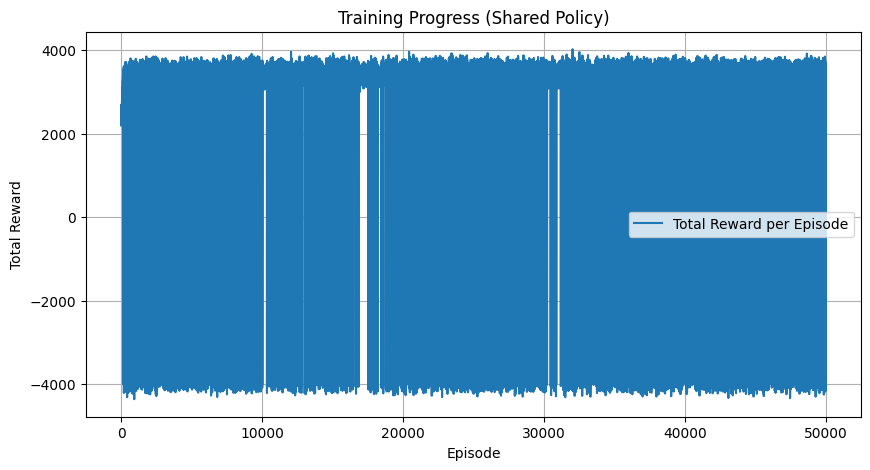

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# 假设所有Agent的观测维度和动作维度相同
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


def train_multiagent(env, num_episodes=3000, gamma=0.99, lr=0.001, reward_threshold=6500):
    """
    使用REINFORCE算法的多智能体训练，每个智能体的策略网络参数共享。
    假设环境里每个智能体的观测空间大小相同、动作空间大小相同。
    """

    # 获取agents列表
    agents = env.agents
    # 以第一个智能体的观测和动作空间来初始化共享网络
    obs_dim = env.observation_space(agents[0]).shape[0]
    act_dim = env.action_space(agents[0]).n

    # 仅创建一个共享策略网络
    shared_policy = PolicyNetwork(obs_dim, act_dim)
    # 仅创建一个优化器
    optimizer = optim.Adam(shared_policy.parameters(), lr=lr)

    total_rewards_history = []

    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")
    for episode in progress_bar:
        obs = env.reset()
        dones = {agent: False for agent in agents}
        done_flag = False

        # 收集当个episode里所有agent的轨迹
        # 因为是共享网络，各agent的轨迹可以合并，也可以分别存储；这里分别存储，方便后面查看和调试
        trajectories = {agent: {"obs": [], "actions": [], "rewards": []} for agent in agents}
        actions_history = []

        while not done_flag:
            actions = {}
            for agent in agents:
                obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
                with torch.no_grad():
                    logits = shared_policy(obs_tensor)
                probs = torch.softmax(logits, dim=-1)
                action = torch.multinomial(probs, 1).item()
                actions[agent] = action
            
            actions_history.append([actions[agent] for agent in agents])
            
            next_obs, rewards, dones, infos = env.step(actions)
            
            # 记录数据
            for agent in agents:
                trajectories[agent]["obs"].append(obs[agent])
                trajectories[agent]["actions"].append(actions[agent])
                trajectories[agent]["rewards"].append(rewards[agent])
            
            obs = next_obs
            done_flag = all(dones.values())
        
        # episode结束后，统一在这里计算损失并更新网络
        optimizer.zero_grad()
        total_loss = 0.0

        # 逐个agent计算回报、对数概率、loss，并累加
        for agent in agents:
            # 计算折扣回报
            returns = []
            G = 0
            for r in reversed(trajectories[agent]["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            
            obs_batch = torch.FloatTensor(trajectories[agent]["obs"])
            action_batch = torch.LongTensor(trajectories[agent]["actions"])
            return_batch = torch.FloatTensor(returns)

            # 前向传播
            logits = shared_policy(obs_batch)
            log_probs = torch.log_softmax(logits, dim=-1)
            chosen_log_probs = log_probs.gather(1, action_batch.unsqueeze(1)).squeeze(1)

            # REINFORCE loss
            loss = -(chosen_log_probs * return_batch).mean()
            total_loss += loss

        # 反向传播并更新一次（累加所有Agent的梯度）
        total_loss.backward()
        optimizer.step()

        # 记录并可视化
        total_reward_this_episode = sum([sum(trajectories[agent]["rewards"]) for agent in agents])
        total_rewards_history.append(total_reward_this_episode)

        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards_history[-10:]) if len(total_rewards_history) >= 10 else total_reward_this_episode
            progress_bar.set_postfix({"Avg Reward (last 10 episodes)": avg_reward})

        if total_reward_this_episode >= reward_threshold:
            for step in actions_history:
                print(step)  # 按行输出动作选择矩阵
            print("=======!!!!!!!!!!!!!!!=======")

    return total_rewards_history, shared_policy

# 在此处引入你的自定义环境
from env_new.MAenv_shared import CustomMAEnvironment

if __name__ == "__main__":
    # 创建环境（假设有5个智能体，环境逻辑与你原代码保持一致）
    env = CustomMAEnvironment(num_agents=5, num_iterations=200, dt=0.1)
    
    # 开始训练
    rewards_history, shared_policy = train_multiagent(
        env, 
        num_episodes=50000, 
        gamma=0.99, 
        lr=0.001
    )
    
    # 保存训练曲线
    np.save("rewards_history_demo_shared.npy", rewards_history)
    print("Rewards history saved")

    # 仅保存一个共享策略网络
    torch.save(shared_policy.state_dict(), "shared_policy.pth")
    print("Saved shared policy to shared_policy.pth")

    # 绘制总体回报曲线
    plt.figure(figsize=(10,5))
    plt.plot(rewards_history, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress (Shared Policy)")
    plt.legend()
    plt.grid(True)
    plt.show()


Rewards history loaded successfully.
Top 1: Reward = 4019.28, Step = 32037
Top 2: Reward = 3959.58, Step = 20435
Top 3: Reward = 3958.58, Step = 12056
Top 4: Reward = 3950.72, Step = 32520
Top 5: Reward = 3929.92, Step = 36003
Top 6: Reward = 3926.8999999999996, Step = 26011
Top 7: Reward = 3922.14, Step = 15041
Top 8: Reward = 3917.02, Step = 23436
Top 9: Reward = 3915.08, Step = 48664
Top 10: Reward = 3913.5199999999995, Step = 23475


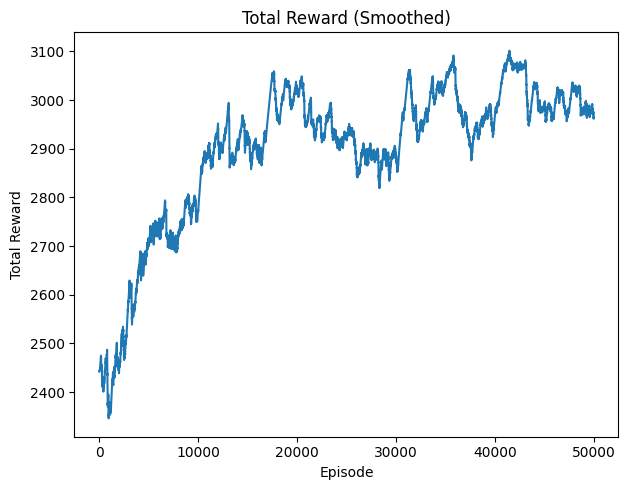

In [8]:

import numpy as np

# 加载 total_rewards_history 文件
loaded_rewards_history = np.load("rewards_history_demo_shared.npy")
print("Rewards history loaded successfully.")
# 使用平滑函数对数据进行平滑处理


# 找到前十最大的值及其对应的时间步
top_10_indices = np.argsort(loaded_rewards_history)[-10:][::-1]  # 按降序排列的索引
top_10_rewards = loaded_rewards_history[top_10_indices]  # 对应的奖励值

# 打印前十的值及其时间步
for i, (reward, step) in enumerate(zip(top_10_rewards, top_10_indices)):
    print(f"Top {i+1}: Reward = {reward}, Step = {step}")

def smooth(data, weight=0.9995):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_value = last * weight + (1 - weight) * point
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

# 对奖励历史和Q值历史进行平滑
smoothed_reward_history = smooth(loaded_rewards_history)
#smoothed_q_value_history = smooth(q_value_history)

# 绘制平滑后的曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Total Reward (Smoothed)")
plt.plot(smoothed_reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")


plt.tight_layout()
plt.show()
